In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from random import shuffle
import os
import glob
import sys
import cv2
import numpy as np
#import skimage.io as io
AUTOTUNE = tf.data.experimental.AUTOTUNE

print("Tensorflow version =",tf.__version__)
print("Keras version =",tf.keras.__version__)

Tensorflow version = 2.0.0-beta1
Keras version = 2.2.4-tf


In [2]:
class DownsamplerBlock (layers.Layer):
    def __init__(self, ninput, noutput):
        super(DownsamplerBlock,self).__init__()
        self.conv = layers.Conv2D(filters=noutput-ninput,kernel_size=3,strides=2,padding="same", use_bias=True)
        self.pool = layers.MaxPool2D(pool_size = 2,strides = 2,padding = "same")
        self.bn = layers.BatchNormalization(epsilon = 1e-03)
    def call(self, x):
        y = layers.concatenate([self.conv(x), self.pool(x)],axis=-1)
        y = self.bn(y)
        y = layers.ReLU()(y)
        return y

In [3]:
class non_bottleneck_1d (layers.Layer):
    def __init__(self, chann, dropprob, dilated):        
        super(non_bottleneck_1d,self).__init__()
        self.conv3x1_1 = layers.Conv2D(filters=chann,kernel_size=(3, 1),strides=1,padding="same", use_bias=True)
        self.conv1x3_1 = layers.Conv2D(filters=chann,kernel_size=(1, 3),strides=1,padding="same", use_bias=True)
        self.bn1 = layers.BatchNormalization(epsilon=1e-3)
        self.conv3x1_2 = layers.Conv2D(filters=chann,kernel_size=(3, 1),strides=1,padding="same", use_bias=True, dilation_rate=(dilated,1))
        self.conv1x3_2 = layers.Conv2D(filters=chann,kernel_size=(1, 3),strides=1,padding="same", use_bias=True, dilation_rate=(1, dilated))
        self.bn2 = layers.BatchNormalization(epsilon=1e-3)
        self.dropout = layers.Dropout(dropprob)
    def  call(self, input, training=False):
        y = self.conv3x1_1(input)
        y = layers.ReLU()(y)
        y = self.conv1x3_1(y)
        y = self.bn1(y)
        y = layers.ReLU()(y)
        y = self.conv3x1_2(y)
        y = layers.ReLU()(y)
        y = self.conv1x3_2(y)
        y = self.bn2(y)
        if training:
            y = self.dropout(y)
        y = layers.add([input, y])
        return layers.ReLU()(y)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 1280, 720, 3)]    0         
_________________________________________________________________
downsampler_block (Downsampl (None, 640, 360, 16)      428       
_________________________________________________________________
downsampler_block_1 (Downsam (None, 320, 180, 64)      7216      
_________________________________________________________________
non_bottleneck_1d (non_bottl (None, 320, 180, 64)      49920     
_________________________________________________________________
non_bottleneck_1d_1 (non_bot (None, 320, 180, 64)      49920     
_________________________________________________________________
non_bottleneck_1d_2 (non_bot (None, 320, 180, 64)      49920     
_________________________________________________________________
non_bottleneck_1d_3 (non_bot (None, 320, 180, 64)      4992

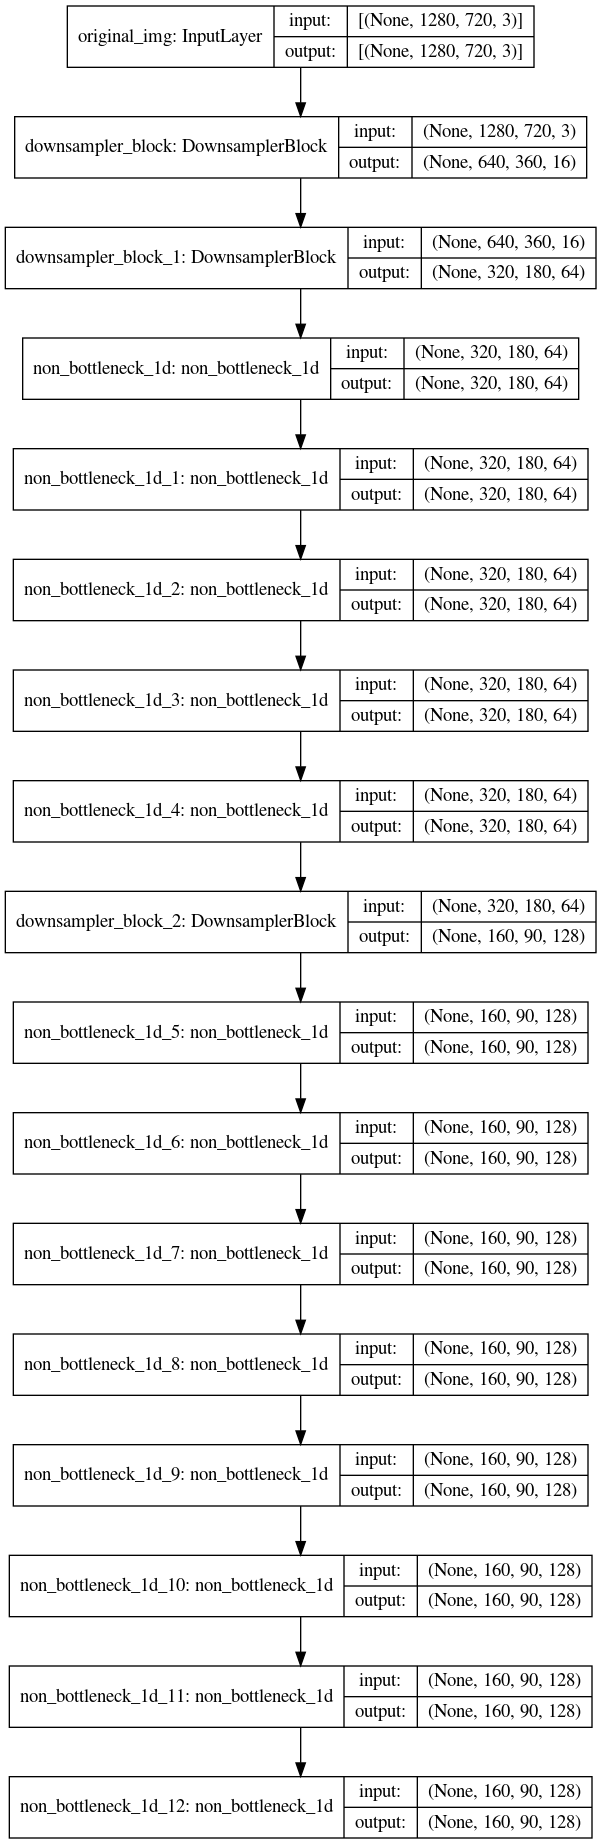

In [4]:
encoder_input = tf.keras.Input(shape=(1280, 720, 3), name='original_img')
y = DownsamplerBlock(3,16)(encoder_input)
y = DownsamplerBlock(16,64)(y)
for i in range (0,5):
    y = non_bottleneck_1d(64, 0.03, 1)(y)
y = DownsamplerBlock(64,128)(y)
for i in range (0,2):
    y = non_bottleneck_1d(128, 0.3, 2)(y)
    y = non_bottleneck_1d(128, 0.3, 4)(y)
    y = non_bottleneck_1d(128, 0.3, 8)(y)
    y = non_bottleneck_1d(128, 0.3, 16)(y)
encoder_output = y
encoder = tf.keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()
tf.keras.utils.plot_model(encoder, 'encoder2.png', show_shapes=True, expand_nested=True)

In [8]:
class UpsamplerBlock (layers.Layer):
    def __init__(self, noutput):
        super(UpsamplerBlock,self).__init__()
        self.conv = layers.Conv2DTranspose(filters=noutput, kernel_size=3, strides=2, padding="same", output_padding=1, use_bias=True)
        self.bn = layers.BatchNormalization(epsilon=1e-3)
    def call(self, x):
        y = self.conv(x)
        y = self.bn(y)
        y = layers.ReLU()(y)
        return y

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_out (InputLayer)     [(None, 160, 90, 128)]    0         
_________________________________________________________________
upsampler_block_9 (Upsampler (None, 320, 180, 64)      74048     
_________________________________________________________________
non_bottleneck_1d_33 (non_bo (None, 320, 180, 64)      49920     
_________________________________________________________________
non_bottleneck_1d_34 (non_bo (None, 320, 180, 64)      49920     
_________________________________________________________________
upsampler_block_10 (Upsample (None, 640, 360, 16)      9296      
_________________________________________________________________
non_bottleneck_1d_35 (non_bo (None, 640, 360, 16)      3264      
_________________________________________________________________
non_bottleneck_1d_36 (non_bo (None, 640, 360, 16)      3264

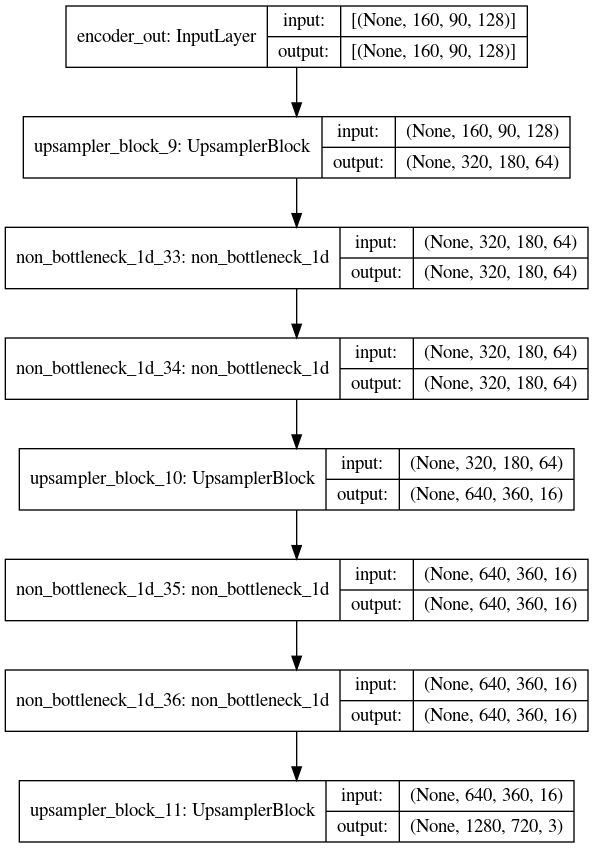

In [14]:
decoder_input = tf.keras.Input(shape= (encoder.output_shape[1:]), name='encoder_out')
#Upsampler Block 64
y = UpsamplerBlock(64)(decoder_input)
#Non bottleneck 64, 1 dilation
y = non_bottleneck_1d(64, 0.03, 1)(y)
y = non_bottleneck_1d(64, 0.03, 1)(y)
#Upsampler Block 16
y = UpsamplerBlock(16)(y)
#Non bottleneck 16, 1 dilation
y = non_bottleneck_1d(16, 0.03, 1)(y)
y = non_bottleneck_1d(16, 0.03, 1)(y)
#Upsampler Block Nb_classes
y = UpsamplerBlock(3)(y)
decoder_output = y
decoder = tf.keras.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()
tf.keras.utils.plot_model(decoder, 'decoder2.png', show_shapes=True, expand_nested=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 1280, 720, 3)]    0         
_________________________________________________________________
encoder (Model)              (None, 160, 90, 128)      1879836   
_________________________________________________________________
decoder (Model)              (None, 1280, 720, 3)      190159    
Total params: 2,069,995
Trainable params: 2,063,397
Non-trainable params: 6,598
_________________________________________________________________


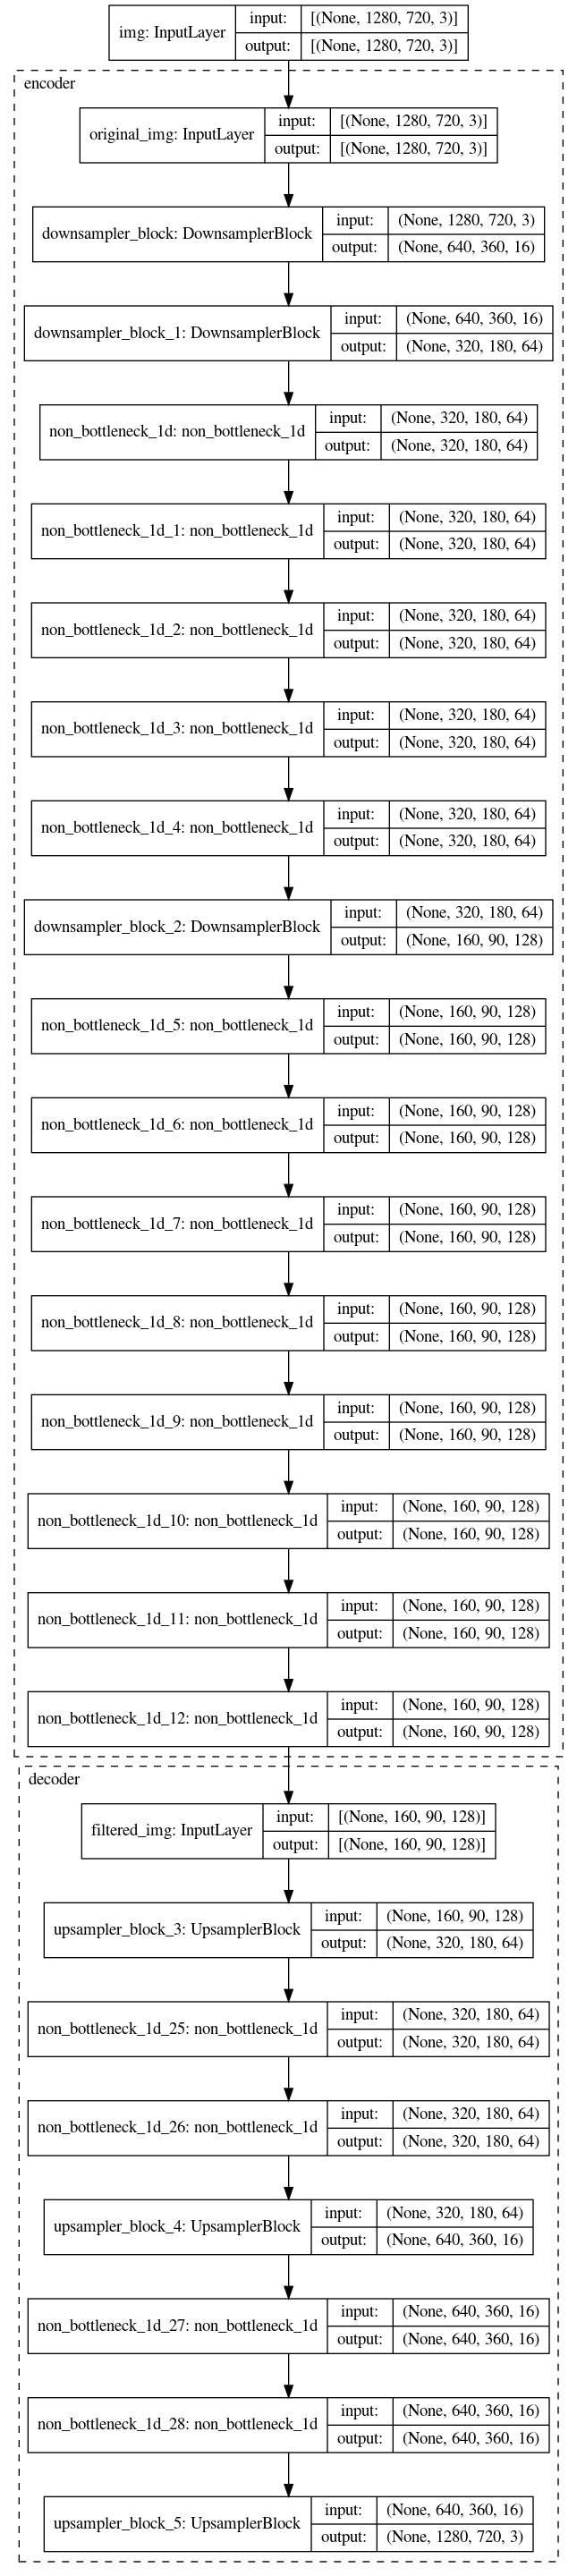

In [12]:
ERFNet_input = tf.keras.Input(shape= (1280,720, 3), name='img')
y = encoder(ERFNet_input)
ERFNet_output = decoder(y)
ERFNet = tf.keras.Model(ERFNet_input, ERFNet_output, name='decoder')
ERFNet.summary()
tf.keras.utils.plot_model(ERFNet, 'ERFNet2.png', show_shapes=True, expand_nested=True)